In [17]:
import io
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time, TimeDelta


In [18]:
# get data for ZTF23abecphw
r = requests.post(
    'https://fink-portal.org/api/v1/objects',
    json={
        'objectId': 'ZTF23abecphw',
        'output-format': 'json',
        'withupperlim': 'True',
    }
)

# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r.content))

In [19]:
len(pdf)

59

In [51]:
def plot_lc(pdf):
    """ Plot photometry contains in an alert
    
    Parameters
    ----------
    pdf: pandas DataFrame
        Pandas DataFrame with single alert row
    """
    fig = plt.figure(figsize=(8, 3))

    # Colors to plot
    colordic = {1: 'C0', 2: 'C1'}

    # Labels of ZTF filters
    filtdic = {1: 'g', 2: 'r'}

    for filt in np.unique(pdf['i:fid']):
        # select data from one filter at a time
        maskFilt = pdf['i:fid'] == filt

        # The column `d:tag` is used to check data type
        maskValid = pdf['d:tag'] == 'valid'
        plt.errorbar(
            pdf[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskValid & maskFilt]['i:magpsf'],
            pdf[maskValid & maskFilt]['i:sigmapsf'],
            ls = '', marker='o', color=colordic[filt], label=filtdic[filt]
        )

        maskUpper = pdf['d:tag'] == 'upperlim'
        plt.plot(
            pdf[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskUpper & maskFilt]['i:diffmaglim'],
            ls='', marker='v', color=colordic[filt], markerfacecolor='none'
        )

        maskBadquality = pdf['d:tag'] == 'badquality'
        plt.errorbar(
            pdf[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
            pdf[maskBadquality & maskFilt]['i:magpsf'],
            pdf[maskBadquality & maskFilt]['i:sigmapsf'],
            ls='', marker='^', color=colordic[filt]
        )

    plt.gca().invert_yaxis()
    plt.legend()
    plt.title(pdf['i:objectId'][0])
    plt.xlabel('Modified Julian Date')
    plt.ylabel('Magnitude')
    plt.show()
    msg = """
    - Circles (●) with error bars show valid alerts that pass the Fink quality cuts. 
    - Upper triangles with errors (▲), represent alert measurements that do not satisfy Fink quality cuts, but are nevetheless contained in the history of valid alerts and used by classifiers.
    - Lower triangles (▽), represent 5-sigma mag limit in difference image based on PSF-fit photometry contained in the history of valid alerts.
    """
    print(msg)

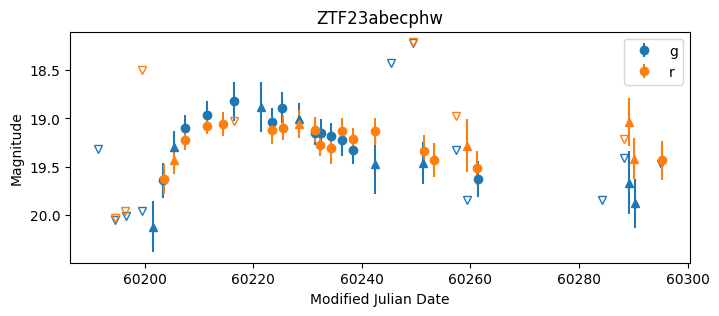


    - Circles (●) with error bars show valid alerts that pass the Fink quality cuts. 
    - Upper triangles with errors (▲), represent alert measurements that do not satisfy Fink quality cuts, but are nevetheless contained in the history of valid alerts and used by classifiers.
    - Lower triangles (▽), represent 5-sigma mag limit in difference image based on PSF-fit photometry contained in the history of valid alerts.
    


In [48]:
plot_lc(pdf)

In [40]:
pdf_datev = pdf[pdf['i:jd']< float(Time('2023-09-25', format='iso').jd)]

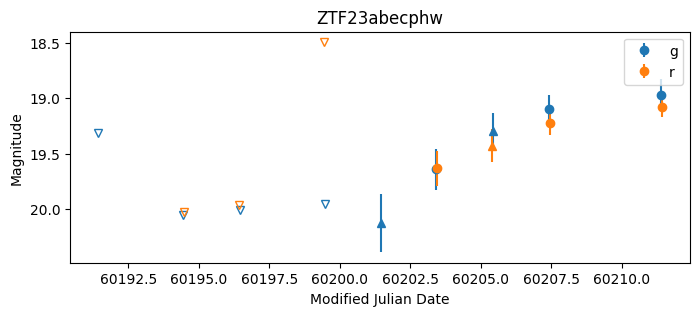


    - Circles (●) with error bars show valid alerts that pass the Fink quality cuts. 
    - Upper triangles with errors (▲), represent alert measurements that do not satisfy Fink quality cuts, but are nevetheless contained in the history of valid alerts and used by classifiers.
    - Lower triangles (▽), represent 5-sigma mag limit in difference image based on PSF-fit photometry contained in the history of valid alerts.
    


In [50]:
plot_lc(pdf_datev.reset_index(drop=True))

In [63]:
pdf_datev[['d:tag','i:jd','i:diffmaglim','i:fid']].sort_values(by='i:jd')

,d:tag,i:jd,i:diffmaglim,i:fid
58,upperlim,2.460192e+06,19.314400,1
57,upperlim,2.460195e+06,20.052300,1
56,upperlim,2.460195e+06,20.029300,2
55,upperlim,2.460197e+06,19.962200,2
54,upperlim,2.460197e+06,20.011400,1
53,upperlim,2.460200e+06,18.494200,2
52,upperlim,2.460200e+06,19.956300,1
51,badquality,2.460202e+06,20.417500,1
50,valid,2.460204e+06,20.534729,1
49,valid,2.460204e+06,20.543188,2


In [72]:
# Step 1: Filter rows where 'd:tag' is 'valid'
validmags_rows = pdf_datev[pdf_datev['d:tag'] == 'valid']
max_mag = validmags_rows['i:magpsf'].max()
# Step 2: For 'upperlim', keep only the first occurrence per 'i:fid'
upperlim_rows = pdf_datev[(pdf_datev['d:tag'] == 'upperlim') & (pdf_datev['i:diffmaglim']>max_mag)].drop_duplicates(subset='i:fid', keep='first')

# Step 3: Combine the valid rows with the first occurrences of 'upperlim'
result = pd.concat([validmags_rows, upperlim_rows])

In [73]:
result

,d:nalerthist,d:x3hsp,i:ssmagnr,d:t2_KN,i:magzpsciunc,i:maggaiabright,i:distpsnr2,i:distpsnr3,i:distpsnr1,i:fink_broker_version,...,v:g-r,v:sigma(g-r),v:rate(g-r),v:sigma(rate(g-r)),v:lastdate,v:firstdate,v:lapse,v:constellation,d:tag,key:time
43,9.0,Unknown,-999.0,0.0,0.000026,12.967827,5.200880,18.546997,5.161732,3.1,...,-0.107611,0.169320,0.005566,0.059655,2023-09-24 10:04:07.997,2023-09-14 11:03:16.004,9.958935,Cetus,valid,NaN
44,8.0,Unknown,-999.0,0.0,0.000041,12.967827,5.407442,18.356293,5.367664,3.1,...,-0.107611,0.169320,0.005566,0.059655,2023-09-24 09:05:41.004,2023-09-14 11:03:16.004,9.918345,Cetus,valid,NaN
45,7.0,Unknown,-999.0,0.0,0.000030,12.967827,5.246176,18.518808,5.206155,3.0,...,-0.129655,0.164782,-0.034854,0.072390,2023-09-20 11:03:07.001,2023-09-14 11:03:16.004,5.999896,Cetus,valid,NaN
46,6.0,Unknown,-999.0,0.0,0.000044,12.967827,5.344610,18.441840,5.303676,3.0,...,-0.129655,0.164782,-0.034854,0.072390,2023-09-20 10:02:27.997,2023-09-14 11:03:16.004,5.957778,Cetus,valid,NaN
49,3.0,Unknown,-999.0,0.0,0.000031,12.967827,5.115118,18.634647,5.075771,3.0,...,0.010477,0.239906,NaN,NaN,2023-09-16 11:04:44.003,2023-09-14 11:03:16.004,2.001019,Cetus,valid,NaN
50,2.0,Unknown,-999.0,0.0,0.000063,12.967827,5.241977,18.473673,5.204965,3.0,...,0.010477,0.239906,NaN,NaN,2023-09-16 09:32:56.003,2023-09-14 11:03:16.004,1.937269,Cetus,valid,NaN
52,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,None,NaN,None,upperlim,1.696796e+12
55,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,None,NaN,None,upperlim,1.696796e+12


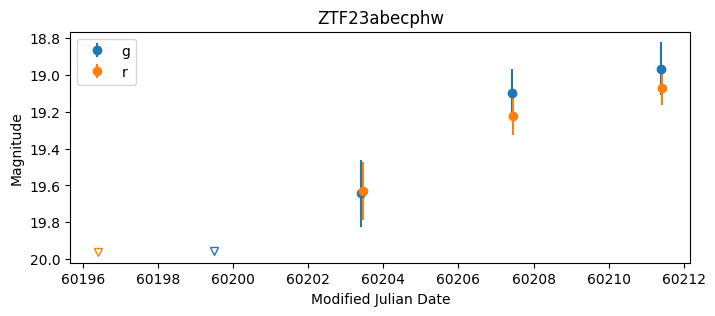


    - Circles (●) with error bars show valid alerts that pass the Fink quality cuts. 
    - Upper triangles with errors (▲), represent alert measurements that do not satisfy Fink quality cuts, but are nevetheless contained in the history of valid alerts and used by classifiers.
    - Lower triangles (▽), represent 5-sigma mag limit in difference image based on PSF-fit photometry contained in the history of valid alerts.
    


In [71]:
plot_lc(result.reset_index(drop=True))